# Follow Me - Write Up

### INDEX

- ####  Data Analisys
        dron camera diagrams
         Encoding and decoding files
         nice presentation
           
- ####  Data Gathering
        train data + extra data
           total data and some stats
- ####  Network Analysis
        network diagram + analisys --> tensors shapes 
- ####  HyperParameters + Training and Results
        selection bases on paper -- reference (fully conv nets for semantic segmentation learning_rate = 10-3)
         
        the results after AWS
- ####  Further developments
        Depth decoder from raw image --> depth camera vs computing depth?
        New objects detection type --> trees, roads, buildings --> How do we obtain the masked images?
        



In [12]:
#LOAD MODULES
import os
import glob
import sys
from tqdm import tqdm_notebook as tqdm
from random import randint
import matplotlib
import numpy as np
import pickle
import tensorflow as tf

from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

The dron has 4 cameras with different views/ranges:
    1. World 
    2. People
    3. Camera
    4. Depth

The files are labeled as follow for one of the four cameras  "cam( number )_( 5 digits number )"

With a simple script we can extract and visualize the different camera views

In [13]:
#Load all images from selected folder in a sorted list with the 4 camera views
print(os.getcwd())
folder = '../data/raw_sim_data/train/IMG/'

def img_to_list(folder, image_type):
    img_list = glob.glob(folder +'*.' + str(image_type))
    return img_list

images =sorted(img_to_list(folder, 'png'))

steps = int(len(images)/4)
dron_images_list = []
for i in range(0,steps):
    cameras_pick = []
    for j in range(0,4):
        cameras_pick.append(images[i+j*steps])
    dron_images_list.append(cameras_pick)


I:\Projects\RoboND-DeepLearning-Project\code


In [51]:
def plot_images_together(ran_images):
    #generate a border for between images
    border = np.zeros((ran_images[0].shape[0],10,3))
    img_concat = np.concatenate((ran_images[0],border),axis=1)
    for i in ran_images[1:]:
        img_concat = np.concatenate((img_concat,border,i),axis=1)

    plt.figure(figsize=(10,5))
    plt.imshow(img_concat)
    plt.show()

In [53]:
# with this information we can create the mask for training our algorithms
# As is developed in this project we need to generate a RGB image with:
#   BLUE channel = pixel from the image one
def mask_img(imag):
    imag = imag.copy()
    imag[imag==1] = 0
    imag[imag!=0] = 1
    return imag
#new imag with all zeros from the shape of the original images
img = np.zeros(ran_images[1].shape)
#get the simulator images and build the masks
people = mask_img(ran_images[1].copy())
hero = mask_img(ran_images[2].copy())
no_world = people + hero
mask = (no_world[:,:,0] == 0)
#blend mask together (world,people,hero)
img[:,:,0][mask] = 1
img[:,:,1] = people[:,:,0]
img[:,:,2] = hero[:,:,0]
#create isolated mask for visualization porpuses
red_mask = np.zeros(img.shape)
red_mask[:,:,0]=img[:,:,0]
green_mask = np.zeros(img.shape)
green_mask[:,:,1]=img[:,:,1]
blue_mask = np.zeros(img.shape)
blue_mask[:,:,2]=img[:,:,2]

#list images + channel mask
channels = []
channels.append(red_mask)
channels.append(green_mask)
channels.append(blue_mask)
channels.append(img)

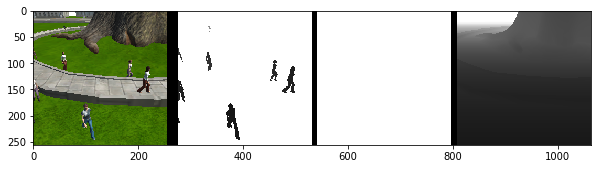

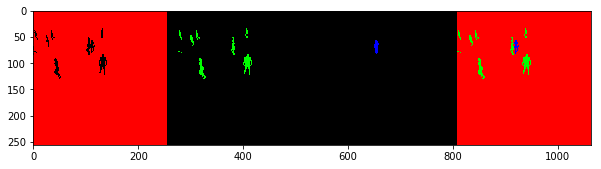

NameError: name 'image_stats' is not defined

In [64]:
# Select a random number and load the pictures for visualization
it = randint(0,steps)
ran_images = [np.array(mpimg.imread(img)) for img in dron_images_list[it]]
plot_images_together(ran_images)
#Visualization of masks creation
plot_images_together(channels)

image_stats(ran_images[0])

#### Image Histrogram analysis

In [65]:
def compute_channels_hist(img,bins = 255, print_diagrams = False):
    
    bn = bins
    histograms = [np.histogram(analysis_img[:,:,i],bins = bn) for i in range(0,3)]
    histogram = histograms[0][0] + histograms[1][0] + histograms[2][0]
    
    if print_diagrams:
        plt.title('histograms')
        g_channel, = plt.plot(histograms[1][0], 'green')
        b_channel, = plt.plot(histograms[2][0], 'blue')
        r_channel, = plt.plot(histograms[0][0], 'red')
        plt.plot(histogram, 'black')
        plt.legend([r_channel,g_channel, b_channel], ['Red', 'Green', 'Blue'])
        plt.show()
    return histograms

[max,min,mean,standard deviation]
[0.92156863, 0.0, 0.38785496, 0.23007134]


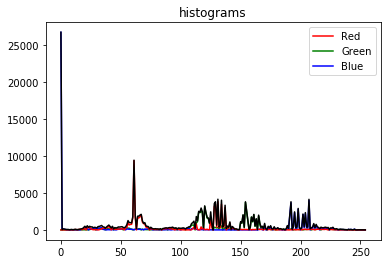

In [68]:
#from tkinter.filedialog import askopenfilename
#filename = askopenfilename()
filename = 'I:/Projects/RoboND-DeepLearning-Project/data/raw_sim_data/train/IMG/cam1_00001.png'
analysis_img = mpimg.imread(filename)
'''
it = randint(0,steps)

ran_images = [np.array(mpimg.imread(img)) for img in dron_images_list[it]]
analysis_img = ran_images[0]
'''
def image_stats(img_path):
    # compute stats for an image
    # input: an string containing the path of the image
    # output: stats = [max,min,mean,standard deviation]
    analysis_img = mpimg.imread(filename)
    stats = []
    stats.append(np.amax(analysis_img))
    stats.append(np.amin(analysis_img))
    stats.append(np.mean(analysis_img))
    stats.append(np.std(analysis_img))
    return stats
print('[max,min,mean,standard deviation]')
print(image_stats(filename))

histograms = compute_channels_hist(analysis_img, 255,True)

In [56]:
#Data for training analysis

#folders
train_folder = '../data/train/images/'
validation_folder = '../data/validation/images/'

#load paths 
train_images = sorted(img_to_list(train_folder, 'jpeg'))
validation_images =  sorted(img_to_list(validation_folder,'jpeg'))

#load images, comput stats and add to list [mean, standar deviation] 
train_means = []
train_stds = []


for it in tqdm(train_images):
    stats = image_stats(it)
    train_means.append(stats[2])
    train_stds.append(stats[3])

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


NameError: name 'image_stats' is not defined

In [57]:
print('train images = ',len(train_images))
print('validation images = ',len(validation_images))

train images =  4131
validation images =  1184


In [59]:
# SAVE THE STATS
if not save_stats:
    save_stats = []
    save_stats.append(train_means)
    save_stats.append(train_stds)
    with open('../train_stats.p', "wb" ) as file:
        pickle.dump( save_stats, file )

In [4]:
# LOAD THE STATS 
save_stats = pickle.load(open('../train_stats.p', "rb" ))

In [58]:
print('mean = ',np.mean(save_stats[0]))
print('std mean = ',np.mean(save_stats[1]))

mean =  97.4002531888
std mean =  63.1252946466


### Input
- input layer size [None, 160, 160, 3]

### Encoder Blocks
- encod1 layer size [None, 80, 80, 32]
- encod2 layer size [None, 40, 40, 64]
- encod3 layer size [None, 20, 20, 128]
- encod4 layer size [None, 10, 10, 256]
- encod5 layer size [None, 5, 5, 512]

### 1x1 Convolution
- conv_layer layer size [None, 5, 5, 512]

### Decoder Blocks
- decoder1  layer size [None, 10, 10, 512]
- decoder2  layer size [None, 20, 20, 256]
- decoder3  layer size [None, 40, 40, 128]
- decoder4  layer size [None, 80, 80, 64]
- decoder5  layer size [None, 160, 160, 32]

### Output
- output layer size [None, 160, 160, 3]